In [1]:
import numpy as np 
from scipy.optimize import minimize, LinearConstraint
from scipy.stats import ortho_group
from scipy.special import erfc
from scipy.integrate import quad, dblquad
from scipy.linalg import cholesky
import matplotlib.pyplot as plt 
import seaborn as sns
plt.rcParams['axes.spines.top'] = False  
plt.rcParams['axes.spines.right'] = False

import jax.numpy as jnp 
from jax import value_and_grad, vmap, random, jit
from jax.scipy.special import erf
from jax.nn import sigmoid
from jax.example_libraries import optimizers
from tqdm import tqdm

outdir = '/mnt/home/awakhloo/ceph/population_geometry_opt_coding/results'
figdir = '/mnt/home/awakhloo/ceph/population_geometry_opt_coding/figures/pngs'

In [2]:
def theta(x): 
    return 1*(x>0)

In [3]:
def loss(Psi, Phi, Omega, P): 
    ''' theoretical generalization error '''
    T1 = jnp.pi/P * jnp.trace(Psi@Psi.T) * jnp.trace(Omega) 
    T2 = 2 * (jnp.trace(Phi.T @ Psi @ Phi) - jnp.trace(Phi.T@Phi)**2/jnp.trace(Omega)) 
    T3 = jnp.sqrt(2) * jnp.trace(Phi@Phi.T)
    return 1/jnp.pi * jnp.arctan(jnp.sqrt(jnp.trace(Omega)*(T1+T2))/T3)

def C_loss(X, N,D,P,Omega_12, Omega):
    ''' Loss in terms of the cholesky decomposition of the block covariance '''
    X1, X2 = X 
    L = jnp.block([[Omega_12, jnp.zeros((D,N))], [X1, X2]])
    C = L @ L.T
    Psi = C[D:, D:] 
    Phi = C[D:, :D]
    return loss(Psi, Phi, Omega, P)

def opt_X(X0, num_steps, lr, mass, loss_fn): 
    # init_fn, update, get_params = optimizers.momentum(lr, mass)
    init_fn, update, get_params = optimizers.adam(lr)
    state = init_fn(X0) 
    losses = [] 
    def step(step, state): 
        val, grad = value_and_grad(loss_fn)(get_params(state))
        state = update(step, grad, state) 
        return val, state 
    
    for i in tqdm(range(num_steps)): 
        val, state = step(i, state) 
        losses.append(val) 
    return get_params(state), losses



In [4]:
def draw_data(Psi, Phi, Omega, P, num_tasks, num_test): 
    '''  
    Returns PxN data and num_tasks x P labels
    '''
    N, D = Phi.shape
    C = np.block([[Psi, Phi], [Phi.T, Omega]])
    eigs, _ = np.linalg.eigh(C)
    if eigs.min() <= -1e-10: 
        print('Min eigenvalue = ', eigs.min())
    vec = np.random.multivariate_normal(mean=np.zeros(N+D), cov=C, size=(P+num_test))
    x, z = vec[:, :N], vec[:, N:] 
    Ts = np.random.randn(num_tasks, D)
    y = np.sign(np.einsum('mi, si -> sm', z, Ts)) 
    return x, y 

def get_empirical_error(Psi, Phi, Omega, P, num_tasks, num_test=5):
    x,y = draw_data(Psi, Phi, Omega,P, num_tasks, num_test)
    x_train, y_train = x[:P], y[:, :P] 
    Ws = np.einsum('ml, sm -> sl', x_train, y_train) / P 
    yhat = np.sign(np.einsum('ml, sl -> sm', x[P:], Ws))
    return np.mean(theta(-y[:, P:]*yhat))


In [5]:
def get_stats(X, N, D, P, Omega_12, Omega,oms, L=None, n_task=20_000): 
    X1, X2 = X 
    L = jnp.block([[Omega_12, jnp.zeros((D,N))], [X1, X2]])
    C = L @ L.T
    Psi = C[D:, D:] 
    Phi = C[D:, :D]
    Omg = C[:D, :D]
    assert np.allclose(Omg, Omega), np.mean(np.square(Omg-Omega))
    stats = {'Psi' : Psi, 'Phi' : Phi, 'PR' : np.trace(Psi)**2/  np.trace(Psi@Psi.T) }
    stats['Eg'] = loss(Psi, Phi, Omega, P)
    stats['Et'] = 1/2 * erfc(np.sqrt(stats['PR'] / P))

    # empirical error from opt soln
    err = get_empirical_error(Psi, Phi, Omega, P, num_tasks=n_task)
    stats['Eg_emp'] = err 

    # EXACT SOLUTION
    psi = oms / (2 * P * oms + np.sum(oms) * np.pi)
    phis = oms * psi 
    Psi, Phi = np.diag(psi), np.diag(phis) 
    stats['Eg_th'] =  loss(Psi, Phi, Omega, P)
    stats['PR_th'] =  np.sum(psi)**2 / np.sum(psi**2)
    stats['c_th'] = np.sum(phis) / np.sum(psi) / np.sum(oms)
    stats['a_th'] = 1/(np.sum(phis*psi) / np.sum(psi) / np.sum(phis) ) 
    stats['f_th'] = np.sum(phis)**2 / np.sum(oms) / np.sum(phis**2/oms) 
    # stats['sa_th'] = 
    stats['psi_th'] = psi
    stats['phi_th'] = phis # note that these are the squared singular vals!! 
    stats['Et_th']= 1/2 * erfc(np.sqrt(stats['PR_th']/P)) # random pattern err
    return stats
    

In [6]:
N = 200
D = 100
np.random.seed(23423)

alpha = 0.5
oms = (1+np.arange(D)) ** (-alpha)
O = ortho_group.rvs(D) 
Omega = O @ np.diag(oms) @ O.T
Omega_12 = cholesky(Omega, lower=True) 
X0 = (np.random.randn(N,D)/np.sqrt(N), np.random.randn(N, N)/np.sqrt(N))


In [7]:
Ps = np.logspace(1, 3, 31, dtype=int)
all_stats = [] 
num_steps = 100
mass = 0.9
lr = 1e-1

for i, P in enumerate(Ps): 
    # alignment ansatz 
    obj = lambda X : C_loss(X,N,D,P, Omega_12, Omega) 
    X, losses = opt_X(X0, num_steps, lr, mass, obj)
    # stats
    stats = get_stats(X, N, D, P, Omega_12, Omega, oms) 
    all_stats.append(stats) 

df = {}
for key in stats.keys(): 
    df[key] = np.stack([st[key] for st in all_stats])

100%|██████████| 100/100 [00:04<00:00, 21.84it/s]
/tmp/ipykernel_1503598/1251121861.py:10: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  vec = np.random.multivariate_normal(mean=np.zeros(N+D), cov=C, size=(P+num_test))


Min eigenvalue =  -4.251634167248032e-08


100%|██████████| 100/100 [00:01<00:00, 61.27it/s]


Min eigenvalue =  -3.344200199388786e-08


100%|██████████| 100/100 [00:01<00:00, 59.24it/s]


Min eigenvalue =  -4.07438744526186e-08


100%|██████████| 100/100 [00:01<00:00, 60.56it/s]


Min eigenvalue =  -3.736008720568069e-08


100%|██████████| 100/100 [00:01<00:00, 55.32it/s]


Min eigenvalue =  -4.0162175265520595e-08


100%|██████████| 100/100 [00:01<00:00, 58.24it/s]


Min eigenvalue =  -3.59705908977213e-08


100%|██████████| 100/100 [00:01<00:00, 58.53it/s]


Min eigenvalue =  -3.565448675232119e-08


100%|██████████| 100/100 [00:01<00:00, 56.43it/s]


Min eigenvalue =  -3.785894355138803e-08


100%|██████████| 100/100 [00:01<00:00, 56.05it/s]


Min eigenvalue =  -3.4087895048885504e-08


100%|██████████| 100/100 [00:01<00:00, 55.56it/s]


Min eigenvalue =  -3.34796852790112e-08


100%|██████████| 100/100 [00:01<00:00, 57.59it/s]


Min eigenvalue =  -3.5045421614918986e-08


100%|██████████| 100/100 [00:01<00:00, 57.45it/s]


Min eigenvalue =  -3.282207977983094e-08


100%|██████████| 100/100 [00:01<00:00, 57.29it/s]


Min eigenvalue =  -3.436003856991165e-08


100%|██████████| 100/100 [00:01<00:00, 58.34it/s]


Min eigenvalue =  -3.835695368471427e-08


100%|██████████| 100/100 [00:01<00:00, 58.02it/s]


Min eigenvalue =  -3.7528034637824135e-08


100%|██████████| 100/100 [00:01<00:00, 53.56it/s]


Min eigenvalue =  -3.487765322276805e-08


100%|██████████| 100/100 [00:01<00:00, 53.31it/s]


Min eigenvalue =  -3.8005916573036426e-08


100%|██████████| 100/100 [00:01<00:00, 53.23it/s]


Min eigenvalue =  -3.828849468814451e-08


100%|██████████| 100/100 [00:01<00:00, 56.84it/s]


Min eigenvalue =  -3.5460423550417865e-08


100%|██████████| 100/100 [00:01<00:00, 56.45it/s]


Min eigenvalue =  -3.45072851408743e-08


100%|██████████| 100/100 [00:01<00:00, 57.02it/s]


Min eigenvalue =  -2.5438139793006745e-08


100%|██████████| 100/100 [00:01<00:00, 57.08it/s]


Min eigenvalue =  -3.542877327865825e-08


100%|██████████| 100/100 [00:01<00:00, 55.77it/s]


Min eigenvalue =  -2.8919353619164404e-08


100%|██████████| 100/100 [00:01<00:00, 53.43it/s]


Min eigenvalue =  -3.028156188440035e-08


100%|██████████| 100/100 [00:01<00:00, 54.58it/s]


Min eigenvalue =  -3.221933429270245e-08


100%|██████████| 100/100 [00:01<00:00, 54.66it/s]


Min eigenvalue =  -2.5716237038137982e-08


100%|██████████| 100/100 [00:01<00:00, 53.62it/s]


Min eigenvalue =  -2.7705356726946228e-08


100%|██████████| 100/100 [00:01<00:00, 50.27it/s]


Min eigenvalue =  -2.518241552835587e-08


100%|██████████| 100/100 [00:01<00:00, 53.51it/s]


Min eigenvalue =  -3.103976817362919e-08


100%|██████████| 100/100 [00:01<00:00, 53.18it/s]


Min eigenvalue =  -3.16786880291796e-08


100%|██████████| 100/100 [00:01<00:00, 51.52it/s]


Min eigenvalue =  -3.0191678747638964e-08


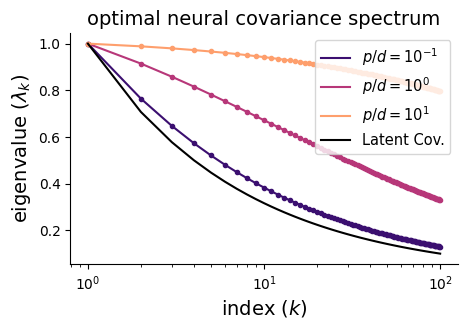

In [8]:
fig = plt.figure(figsize=(5,3))
fn = 14
i_targs = [0, 15, 30]
fs = ['10^{-1}', '10^0', '10^1']
resample = np.linspace(0.2, 0.8, len(i_targs))
colors = plt.get_cmap('magma')(resample) 
norm = df['psi_th'][0].max()
j=0
# plt.xscale('log')
X = 1 + np.arange(D)
for i, p in enumerate(Ps):
    if i in i_targs:
        psi_th = df['psi_th'][i]
        norm = psi_th.max()
        plt.semilogx(X, psi_th/norm, label = f'$p/d={fs[j]}$', color=colors[j])
        eigs = np.linalg.eigh(df['Psi'][i])[0]
        psi_emp = np.flip(eigs)[:len(psi_th)]
        norm_e = psi_emp.max() 
        plt.semilogx(X, psi_emp/norm_e, marker='.', ls='', color=colors[j])
        j+=1
plt.semilogx(X, oms, label='Latent Cov.', color='black')
# plt.xscale('log')
plt.xlabel('index $(k)$', fontsize=fn)
plt.ylabel('eigenvalue $(\lambda_k)$', fontsize=fn)
plt.title('optimal neural covariance spectrum', fontsize=fn)
# 
# plt.xlim(1,100)
# plt.yscale('log')
plt.legend(fontsize=3*fn/4, loc='upper right')
plt.savefig(figdir + '/f3_new_opt.pdf', dpi=300, bbox_inches='tight')

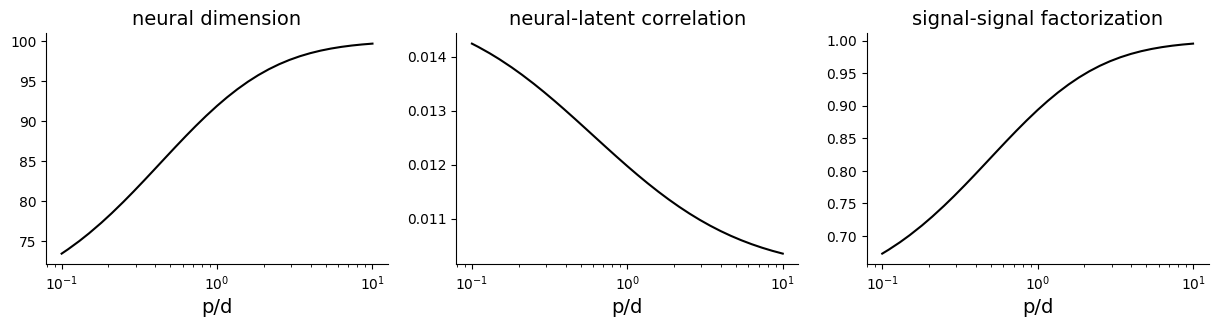

In [9]:
fig, ax = plt.subplots(1,3,figsize=(15,3))
colors = ['k' for _ in range(3)]
ax[0].plot(Ps/D, df['PR_th'], color=colors[0])
ax[0].set_title(r'neural dimension', fontsize=fn)
ax[1].plot(Ps/D, df['c_th'], color=colors[1])
ax[1].set_title(r'neural-latent correlation', fontsize=fn)
ax[2].plot(Ps/D, df['f_th'], color=colors[2])
ax[2].set_title(r'signal-signal factorization',fontsize=fn)

for i in range(3):
    ax[i].set_xscale('log')
    ax[i].set_xlabel('p/d', fontsize=fn)

fig.savefig(figdir + '/f3_geom_P.pdf', dpi=300, bbox_inches='tight')

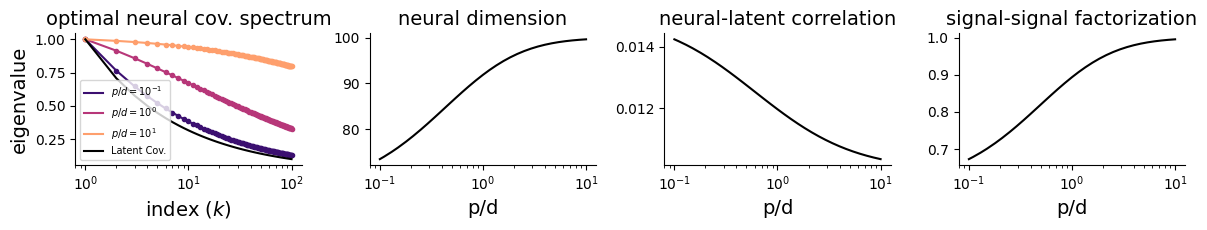

In [10]:
w = 12 
# wh_ratio = 3/20
wh_ratio = 1/5
fig, ax = plt.subplots(1,4,figsize=(w,wh_ratio * w))
fn =14
i_targs = [0, 15, 30]
fs = ['10^{-1}', '10^0', '10^1']
resample = np.linspace(0.2, 0.8, len(i_targs))
colors = plt.get_cmap('magma')(resample) 
norm = df['psi_th'][0].max()
j=0
# plt.xscale('log')
X = 1 + np.arange(D)
for i, p in enumerate(Ps):
    if i in i_targs:
        psi_th = df['psi_th'][i]
        norm = psi_th.max()
        ax[0].semilogx(X, psi_th/norm, label = f'$p/d={fs[j]}$', color=colors[j])
        eigs = np.linalg.eigh(df['Psi'][i])[0]
        psi_emp = np.flip(eigs)[:len(psi_th)]
        norm_e = psi_emp.max() 
        ax[0].semilogx(X, psi_emp/norm_e, marker='.', ls='', color=colors[j])
        j+=1
ax[0].semilogx(X, oms, label='Latent Cov.', color='black')
# plt.xscale('log')
ax[0].set_xlabel('index $(k)$', fontsize=fn)
ax[0].set_ylabel('eigenvalue', fontsize=fn)
ax[0].set_title('optimal neural cov. spectrum', fontsize=fn)
# 
ax[0].legend(fontsize=fn/2)


colors = ['k' for _ in range(3)]
ax[1].plot(Ps/D, df['PR_th'], color=colors[0])
ax[1].set_title(r'neural dimension', fontsize=fn)
ax[2].plot(Ps/D, df['c_th'], color=colors[1])
ax[2].set_title(r'neural-latent correlation', fontsize=fn)
ax[3].plot(Ps/D, df['f_th'], color=colors[2])
ax[3].set_title(r'signal-signal factorization',fontsize=fn)

for i in range(1,4):
    ax[i].set_xscale('log')
    ax[i].set_xlabel('p/d', fontsize=fn)
plt.tight_layout()

fig.savefig(figdir + '/sm_opt_rep_fig.pdf', dpi=300, bbox_inches='tight')